In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load datasets
s_data = pd.read_csv("/content/Original_Dataset.csv")
doc_data = pd.read_csv("/content/Doctor_Versus_Disease.csv", encoding='latin1', names=['Disease', 'Specialist'])
des_data = pd.read_csv("/content/Disease_Description.csv")

In [4]:
# Handle missing values
print("Initial dataset shape:", s_data.shape)
s_data = s_data.fillna("Unknown")  # Replace missing values
print("Dataset after handling missing values shape:", s_data.shape)

# Remove duplicates
print("Duplicates in the dataset:", s_data.duplicated().sum())
s_data = s_data.drop_duplicates()

Initial dataset shape: (4920, 18)
Dataset after handling missing values shape: (4920, 18)
Duplicates in the dataset: 4616


In [5]:
# Preprocess symptom names to remove underscores and normalize case
def clean_symptom_names(df):
    df = df.copy()
    for col in df.columns[1:]:
        df[col] = df[col].str.replace('_', ' ').str.lower()
    return df

s_data = clean_symptom_names(s_data)

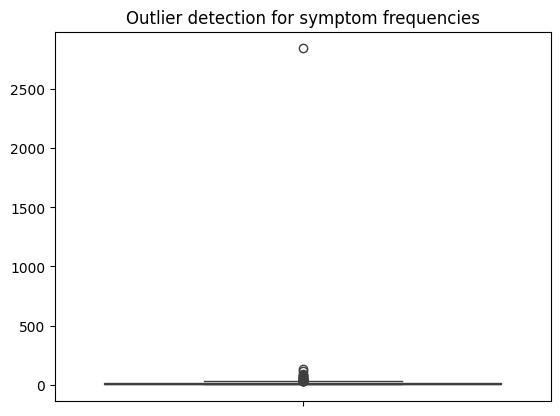

In [6]:
# Outlier detection (example with symptom frequencies)
symptom_counts = s_data.iloc[:, 1:].apply(pd.Series.value_counts).sum(axis=1)
sns.boxplot(symptom_counts)
plt.title("Outlier detection for symptom frequencies")
plt.show()


In [7]:
# Create binary encoding for symptoms
symptoms = s_data.iloc[:, 1:].values.flatten()
symptoms = list(set(symptoms))
new_s_data = s_data.copy()

for symptom in symptoms:
    new_s_data[symptom] = new_s_data.iloc[:, 1:].apply(lambda row: int(symptom in row.values), axis=1)


In [8]:
# Drop the original symptom columns
columns_to_drop = [col for col in s_data.columns if col != 'Disease']
new_s_data = new_s_data.drop(columns=columns_to_drop)


In [9]:
# Encode target variable
label = LabelEncoder()
new_s_data['Disease'] = label.fit_transform(new_s_data['Disease'])


In [10]:
# Split data into train and test sets
X = new_s_data.drop(columns="Disease")
y = new_s_data['Disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

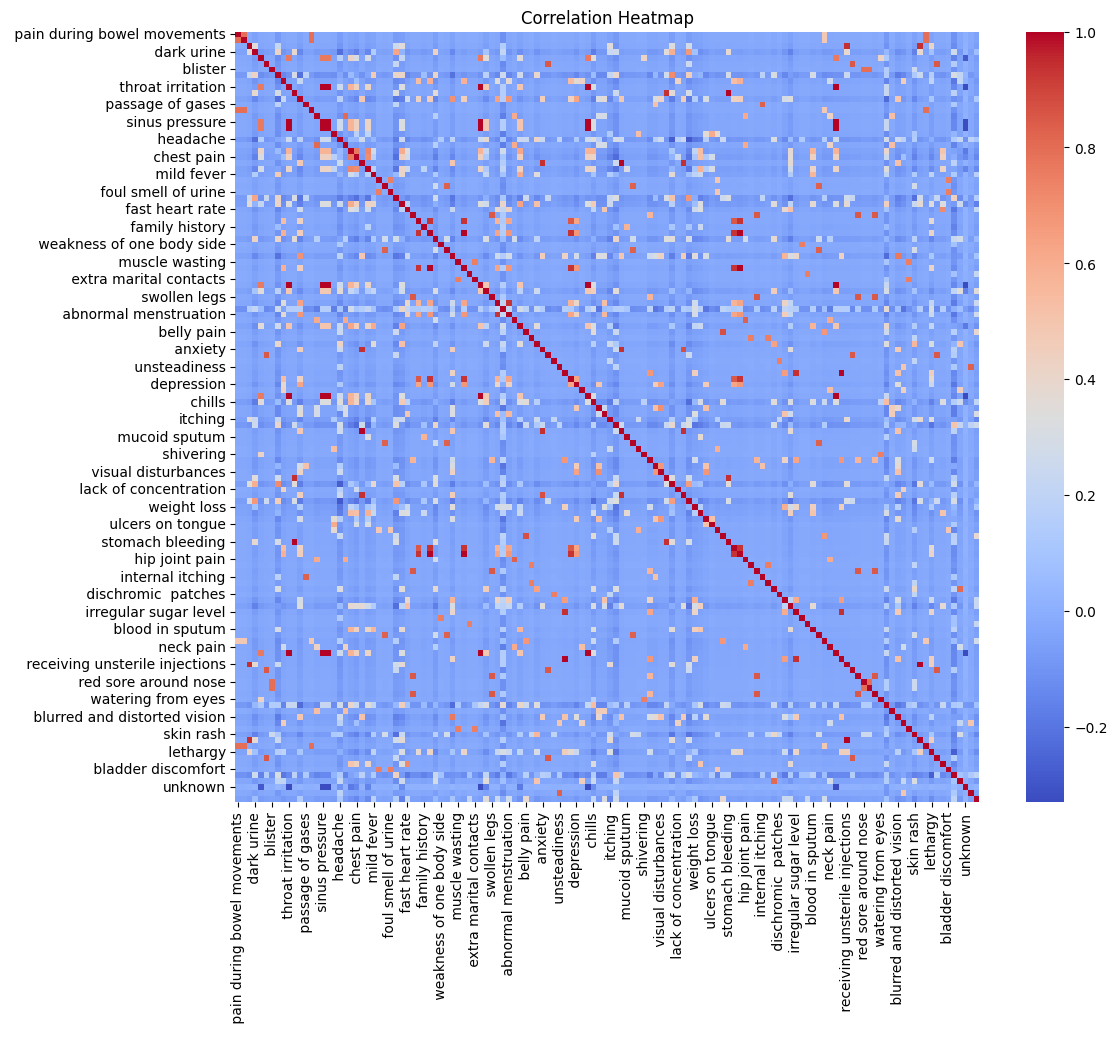

In [11]:
# Correlation heatmap (Optional for Visualization)
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


In [12]:
# Model building
models = {
    'Random Forest': RandomForestClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'MLP Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
}

# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for model_name, model in models.items():
    accuracy_scores = []
    f1_scores = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        accuracy_scores.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))

    results[model_name] = {
        "Accuracy": np.mean(accuracy_scores),
        "F1 Score": np.mean(f1_scores)
    }

# Display results
for model_name, metrics in results.items():
    print(f"{model_name} - Accuracy: {metrics['Accuracy']:.3f}, F1 Score: {metrics['F1 Score']:.3f}")

Random Forest - Accuracy: 1.000, F1 Score: 1.000
CatBoost - Accuracy: 0.992, F1 Score: 0.989
MLP Neural Network - Accuracy: 1.000, F1 Score: 1.000


In [13]:
# Ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('catboost', CatBoostClassifier(verbose=0)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42))
], voting='soft')

ensemble_model.fit(X_train, y_train)
ensemble_accuracy = accuracy_score(y_test, ensemble_model.predict(X_test))
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.3f}")


Ensemble Model Accuracy: 1.000


In [14]:
import pandas as pd
import numpy as np

def test_input():
    print("Welcome to the Symptom Checker!")
    print("Follow the steps below to input your symptoms and get a diagnosis.")

    try:
        while True:  # Loop until valid symptoms are entered
            # Step 1: Ask the user how many symptoms they want to enter
            while True:
                try:
                    num_symptoms = int(input("How many symptoms do you want to enter? "))
                    if num_symptoms <= 0:
                        print("Please enter a positive number.")
                        continue
                    break
                except ValueError:
                    print("Invalid input. Please enter a valid number.")

            # Step 2: Collect symptoms one by one
            symptoms = []
            for i in range(num_symptoms):
                symptom = input(f"Enter symptom {i + 1}: ").strip().lower()
                symptoms.append(symptom)

            # Normalize symptoms and valid columns
            valid_symptoms = [symptom.strip().lower().replace('_', ' ') for symptom in X.columns]
            normalized_input = [symptom.strip().lower().replace('_', ' ') for symptom in symptoms]

            # Validate symptoms
            invalid_symptoms = [symptom for symptom in normalized_input if symptom not in valid_symptoms]

            if invalid_symptoms:
                print("\nThe following symptoms are invalid:")
                for symptom in invalid_symptoms:
                    print(f"- {symptom}")
                print("Please check the symptom names and try again.\n")
                continue  # Restart the loop to collect symptoms again

            # If all symptoms are valid, break out of the validation loop
            break

        # Prepare test data
        test_data = {col: (1 if col.strip().lower().replace('_', ' ') in normalized_input else 0) for col in X.columns}
        test_df = pd.DataFrame([test_data])

        # Make predictions
        prediction_probs = ensemble_model.predict_proba(test_df)
        prediction = ensemble_model.predict(test_df)
        predicted_disease = label.inverse_transform(prediction)[0]
        disease_probability = np.max(prediction_probs) * 100

        # Fetch additional details
        specialist = doc_data[doc_data['Disease'] == predicted_disease]['Specialist'].values[0]
        description = des_data[des_data['Disease'] == predicted_disease]['Description'].values[0]

        # Display results
        print("\n### Diagnosis Results ###")
        print(f"Predicted Disease: {predicted_disease}")
        print(f"Probability of having this disease: {disease_probability:.2f}%")
        print(f"Specialist to Consult: {specialist}")
        print(f"Description: {description}")

        # Follow-up prompt
        while True:
            follow_up = input("\nWould you like to check another set of symptoms? (yes/no): ").strip().lower()
            if follow_up == 'yes':
                test_input()
                break
            elif follow_up == 'no':
                print("Thank you for using the Symptom Checker! Stay healthy.")
                break
            else:
                print("Invalid input. Please enter 'yes' or 'no'.")

    except KeyError as e:
        print(f"Error: {e}. Some information might be missing from the data.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}. Please try again.")

# Example placeholders for required objects (X, ensemble_model, etc.)
# Replace these with your actual model and data definitions
# X = pd.DataFrame(columns=["continuous sneezing", "shivering", "chills"])  # Example symptoms
# ensemble_model = ...  # Trained model
# label = ...  # Label encoder for diseases
# doc_data = pd.DataFrame({'Disease': ['Cold'], 'Specialist': ['General Physician']})  # Example
# des_data = pd.DataFrame({'Disease': ['Cold'], 'Description': ['A viral infection causing sneezing, shivering, and chills.']})  # Example


In [ ]:
# Example test input
test_input()


Welcome to the Symptom Checker!
Follow the steps below to input your symptoms and get a diagnosis.
How many symptoms do you want to enter? 4
Enter symptom 1: chills
Enter symptom 2: fever
Enter symptom 3: continuous sneezing
Enter symptom 4: shivering

The following symptoms are invalid:
- fever
Please check the symptom names and try again.

How many symptoms do you want to enter? 3
Enter symptom 1: chills
Enter symptom 2: shivering
Enter symptom 3: continuous snezing

The following symptoms are invalid:
- continuous snezing
Please check the symptom names and try again.

How many symptoms do you want to enter? 3
Enter symptom 1: chills
Enter symptom 2: shivering
Enter symptom 3: continuous sneezing

### Diagnosis Results ###
Predicted Disease: Allergy
Probability of having this disease: 59.78%
Specialist to Consult: Allergist
Description: An allergy is an immune system response to a foreign substance that's not typically harmful to your body.They can include certain foods, pollen, or p